<a href="https://colab.research.google.com/github/nrzsdy1993/segmentation/blob/main/segmentation_advence.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Segmentation with advence

## 데이터셋: Oxford-IIIT Pets 데이터셋
---
![](https://github.com/yebiny/Image-Segmentation-TF2/blob/main/imgs/oxford-pet.jpeg?raw=true)

### 1. 데이터셋 다운로드

In [ ]:
!curl -O  https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!curl -O  https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
!tar -xf images.tar.gz
!tar -xf annotations.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  755M  100  755M    0     0  27.3M      0  0:00:27  0:00:27 --:--:-- 29.1M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 18.2M  100 18.2M    0     0  9736k      0  0:00:01  0:00:01 --:--:-- 9731k


### 2. 이미지 경로 설정

In [ ]:
import os
from glob import glob

data_dir= '/content/'
#Train
train_img_paths=glob(os.path.join(data_dir,'images/*.jpg'))
train_mask_paths=glob(os.path.join(data_dir,'annotations/trimaps/*.png'))

print(len(train_img_paths),len(train_mask_paths))
print(train_img_paths[:10])
print(train_mask_paths[:10])

train_img_paths=sorted(train_img_paths)
train_mask_paths=sorted(train_mask_paths)



7390 7390
['/content/images/Sphynx_197.jpg', '/content/images/leonberger_143.jpg', '/content/images/Maine_Coon_168.jpg', '/content/images/Ragdoll_99.jpg', '/content/images/english_cocker_spaniel_46.jpg', '/content/images/scottish_terrier_67.jpg', '/content/images/japanese_chin_154.jpg', '/content/images/Ragdoll_255.jpg', '/content/images/newfoundland_144.jpg', '/content/images/american_bulldog_175.jpg']
['/content/annotations/trimaps/boxer_125.png', '/content/annotations/trimaps/pomeranian_58.png', '/content/annotations/trimaps/wheaten_terrier_55.png', '/content/annotations/trimaps/beagle_69.png', '/content/annotations/trimaps/english_cocker_spaniel_129.png', '/content/annotations/trimaps/basset_hound_175.png', '/content/annotations/trimaps/Birman_109.png', '/content/annotations/trimaps/american_bulldog_197.png', '/content/annotations/trimaps/american_pit_bull_terrier_32.png', '/content/annotations/trimaps/shiba_inu_62.png']


## 데이터셋 제너레이터
---

In [ ]:
#img_size=128
#img=img/255 ->0~1 사이 값이 나옴
#img=(img/127.5)-1 ->-1~1 사이 값 나옴
from tensorflow.keras.preprocessing.image import load_img,img_to_array
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot') #plot 스타일 조절

class DataGenerator():
    def __init__(self, img_size, batch_size, ds_name='human'):
        self.img_size = img_size
        self.batch_size = batch_size
        self.ds_name = ds_name

    def path2arr(self, path, mask=False):
        if not mask: 
          arr = load_img(path, target_size=(self.img_size, self.img_size), color_mode='rgb')
          arr = img_to_array(arr, dtype='uint8')
        else:
          arr = load_img(path, target_size=(self.img_size, self.img_size), color_mode='grayscale')
          arr = img_to_array(arr, dtype='uint8')
        
        return arr

    def load_dataset(self, img_paths, mask_paths):
        imgs = []
        masks = []
        for img_path, mask_path in zip(img_paths, mask_paths):
          img = self.path2arr(img_path)
          mask = self.path2arr(mask_path, mask=True)
          imgs.append(img)
          masks.append(mask)
        return np.array(imgs), np.array(masks)

    def preprocess(self, img, mask):

      if self.ds_name=='pet':
        img = (tf.cast(img, tf.float32) / 127.5) -1
        mask = tf.cast(mask, tf.float32)-1
      
      elif self.ds_name=='human':
        img = (tf.cast(img, tf.float32) / 127.5) -1
        mask = tf.cast(mask, tf.float32)
      
      else:
        print("dataset name error")

      return img, mask
    
    def augment(self, img_pre, mask):
      # 밝기 랜덤조정
      img = tf.image.random_brightness(img_pre, max_delta=0.5)
      img = tf.clip_by_value(img, -1, 1)
      
      ds = tf.concat((img, mask), axis=2)
      ## 좌우 반전
      ds =tf.image.random_flip_left_right(ds)
      ## 상하 반전
      ds =tf.image.random_flip_up_down(ds)


      # # 이미지 사이즈 증가
      # pad_size = 50
      # img = tf.image.resize_with_crop_or_pad(img, self.img_size+pad_size,
      #                                        self.img_size+pad_size)
      # mask = tf.image.resize_with_crop_or_pad(mask, self.img_size+pad_size,
      #                                        self.img_size+pad_size)
      

      # # -> 랜덤크롭
      # ds = tf.concat((img, mask), axis=2)
      # ds = tf.image.random_crop(ds, size=[self.img_size, self.img_size, 4])
      img, mask = ds[:, :, :3], ds[:, :, -1]
      # # img = (256, 256, 3)
      # # mask = (256, 256) -> (256, 256, 1)
      mask = tf.expand_dims(mask, axis=2)
      return img, mask
    
    def generate(self, img_paths, mask_paths, aug=False):
        imgs, masks = self.load_dataset(img_paths, mask_paths)
        dataset = tf.data.Dataset.from_tensor_slices((imgs, masks))
        dataset = dataset.map(self.preprocess, num_parallel_calls=tf.data.AUTOTUNE)
        
        if aug:
          dataset = dataset.map(self.augment, num_parallel_calls=tf.data.AUTOTUNE)
          pass
        dataset = dataset.batch(self.batch_size, drop_remainder=True)
        return dataset
    

def hist_val(img_arr,mask_arr):
  plt.figure(figsize=(20,10)) #plt 사이즈 조정
  plt.subplot(1,2,1)
  img_shape=img_arr.shape[0]*img_arr.shape[1]*img_arr.shape[2]
  plt.hist(np.reshape(img_arr,img_shape))#hist는 무조건 1차원 값이 들어가야함

  plt.subplot(1,2,2)
  mask_shape=mask_arr.shape[0]*mask_arr.shape[1]*mask_arr.shape[2]
  plt.hist(np.reshape(mask_arr,mask_shape))
  print(set(np.reshape(mask_arr,mask_shape))) #set은 값들의 중복값은 제거 (112321 -> 123)
  plt.show()



def display_img(img_arr,mask_arr,mask_cmap=None):
  plt.figure(figsize=(12,4))
  
  plt.subplot(1,3,1)
  plt.axis('off')
  plt.imshow(img_arr)

  plt.subplot(1,3,2) #중첩되도록 그림
  plt.axis('off')
  plt.imshow(img_arr)
  plt.imshow(mask_arr[:,:,0],alpha=0.6,cmap=mask_cmap) #alpha 투명도 cmap 컬러맵(기본 값 None)

  plt.subplot(1,3,3)
  plt.axis('off')
  plt.imshow(mask_arr[:,:,0],cmap=mask_cmap)#mask_arr (가로,세로,1)->(가로,세로)

  plt.show()

In [ ]:
IMG_SIZE = 256
BATCH_SIZE=16
dg=DataGenerator(IMG_SIZE,BATCH_SIZE, ds_name='pet')


### 1. array 변환

In [ ]:
idx=12
img_arr=dg.path2arr(train_img_paths[idx])
mask_arr=dg.path2arr(train_mask_paths[idx],mask=True)
print(img_arr.shape,mask_arr.shape)

(256, 256, 3) (256, 256, 1)


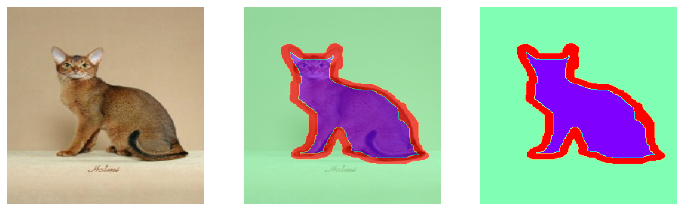

{1, 2, 3}


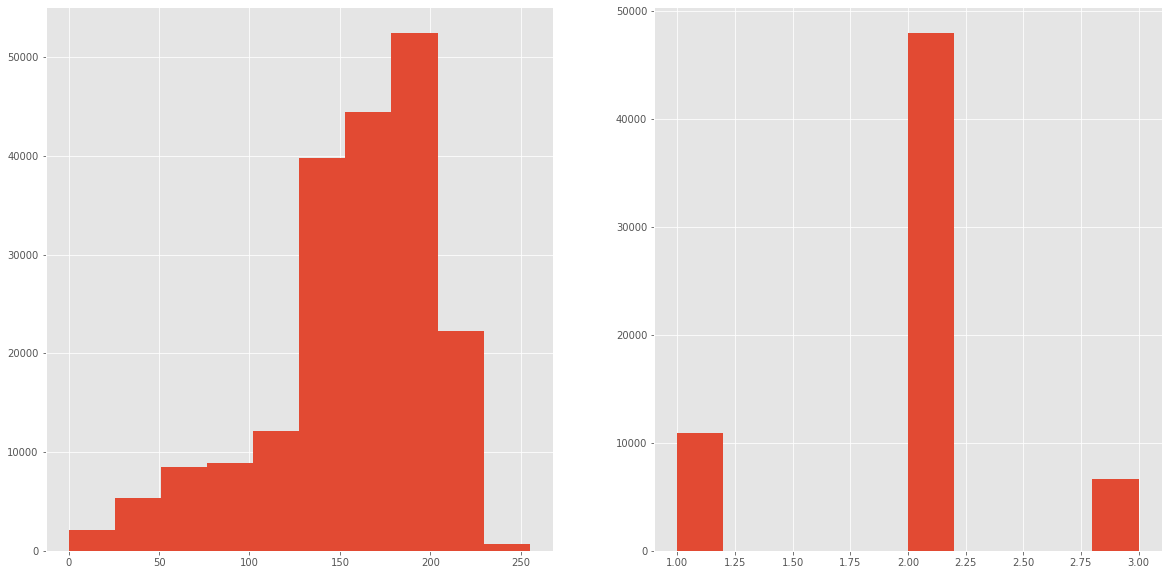

In [ ]:
display_img(img_arr,mask_arr,mask_cmap='rainbow')
hist_val(img_arr,mask_arr)
#img = 0~255 ,imput
#mask = 0~19 ,output(이미지에 마스크가 씌워져서 나옴)

### 2. 전처리

In [ ]:
img_pre,mask_pre=dg.preprocess(img_arr,mask_arr)
print(img_pre.shape,mask_pre.shape)

(256, 256, 3) (256, 256, 1)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


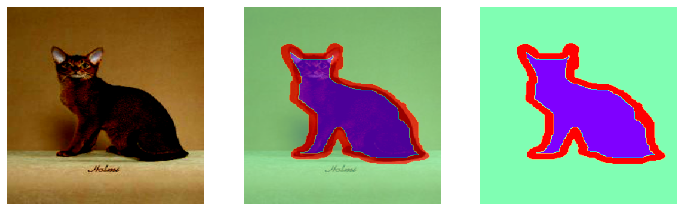

{0.0, 1.0, 2.0}


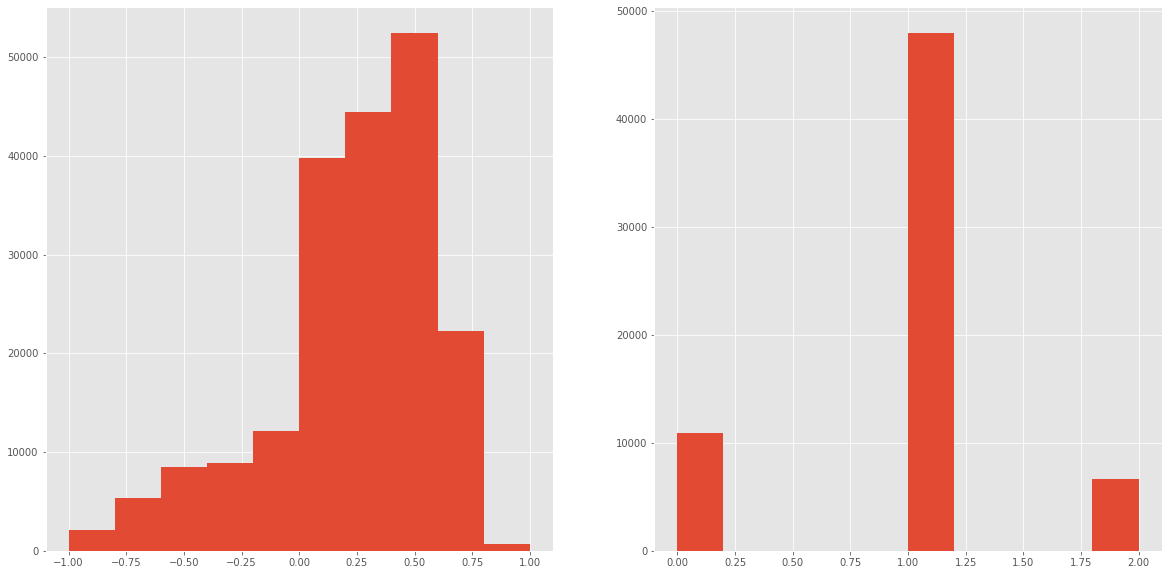

In [ ]:
display_img(img_pre,mask_pre,mask_cmap='rainbow')
hist_val(img_pre,mask_pre)
#img = 0~255 ,imput
#mask = 0~19 ,output(이미지에 마스크가 씌워져서 나옴)

### 3. 데이터셋 정의


In [ ]:
train_ds=dg.generate(train_img_paths[:5000],train_mask_paths[:5000])
valid_ds=dg.generate(train_img_paths[5000:],train_mask_paths[5000:])
print(train_ds)

<BatchDataset shapes: ((16, 256, 256, 3), (16, 256, 256, 1)), types: (tf.float32, tf.float32)>


## 모델: UNet
---

### 1. 모델 생성

In [ ]:
from tensorflow.keras import layers, models, Input, utils

def get_unet(img_size, num_classes):
  inputs = Input(shape=( img_size, img_size, 3) )

  x = layers.Conv2D(32, 3, strides=2, padding='same')(inputs)
  x = layers.BatchNormalization()(x)
  x = layers.Activation('relu')(x)
  x_pre = x

  for filters in [64, 128, 256]:
    #filter :채널
    x = layers.Activation('relu')(x)
    x = layers.SeparableConv2D(filters, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)

    x = layers.Activation('relu')(x)
    x = layers.SeparableConv2D(filters, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)

    x = layers.MaxPooling2D(3, strides=2, padding='same')(x)
    residual = layers.Conv2D(filters, 1, strides=2, padding='same')(x_pre)
    x = layers.add([x, residual])
    x_pre = x

  for filters in [256, 128, 64, 32]:
    x = layers.Activation('relu')(x)
    x = layers.Conv2DTranspose(filters, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)

    x = layers.Activation('relu')(x)
    x = layers.Conv2DTranspose(filters, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)

    x = layers.UpSampling2D(2)(x)

    residual = layers.UpSampling2D(2)(x_pre)
    residual = layers.Conv2D(filters, 1, padding='same')(residual)
    x = layers.add([x, residual])
    x_pre = x

  outputs = layers.Conv2D(num_classes, 3, activation='softmax', padding='same')(x)

  model = models.Model(inputs, outputs)
  return model

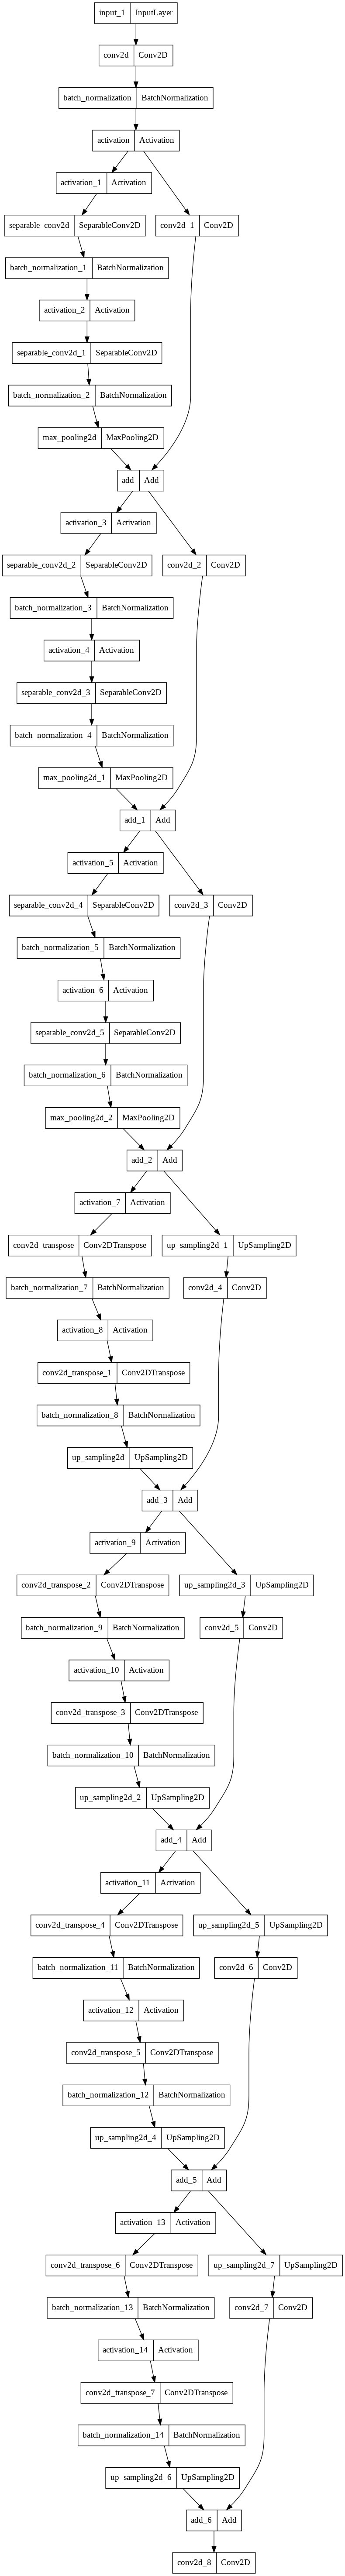

In [ ]:
NUM_CLASSES =20 #mask의 갯수에 맞게 설정, 해당 경우에는 20개이므로 20개
model=get_unet(IMG_SIZE,NUM_CLASSES)
tf.keras.utils.plot_model(model)

### 2. 모델 컴파일

In [ ]:
loss=tf.keras.losses.SparseCategoricalCrossentropy()
optimizer=tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss=loss,optimizer=optimizer,metrics=['accuracy'])

### 3. 모델 학습

In [ ]:
ckp= tf.keras.callbacks.ModelCheckpoint("pet.h5",save_best_only=True)#save_best_only:가장 좋은 모델만 저장하겠다
reduce_lr=tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                               factor=0.2,
                                               patience=5)
history= model.fit(train_ds
                   ,validation_data=valid_ds
                   ,epochs=10
                   ,callbacks=[ckp,reduce_lr]) #callback:학습성능향상 모듈


Epoch 1/10
312/312 [==============================] - ETA: 0s - loss: 0.8255 - accuracy: 0.7034

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


312/312 [==============================] - 217s 580ms/step - loss: 0.8255 - accuracy: 0.7034 - val_loss: 3.2647 - val_accuracy: 0.6013 - lr: 0.0010
Epoch 2/10
118/312 [==========>...................] - ETA: 1:37 - loss: 0.6414 - accuracy: 0.7424

KeyboardInterrupt: ignored

### 4. 모델 평가

In [ ]:
model.evaluate(valid_ds)

### 5. 추론

In [ ]:
import tensorflow as tf
from tensorflow.keras import models
def img_pred(path,model,mask_cmap='rainbow'):
  img_arr=dg.path2arr(path)
  #arr 전처리
  img_pre,_=dg.preprocess(img_arr,img_arr)
  #model load


  model=models.load_model('pet.h5')
  pred=model.predict(tf.expand_dims(img_pre,0))
  print(pred.shape)
  pred=np.argmax(pred,axis=3)
  print(pred.shape)
  pred=np.expand_dims(pred[0],2)
  print(pred.shape)
  display_img(img_arr,pred)

In [ ]:
img_pred('/content/pet3.jpg',model)
img_pred('/content/pet2.jpg',model)

## Generator with augmentation
---


### augmentation

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


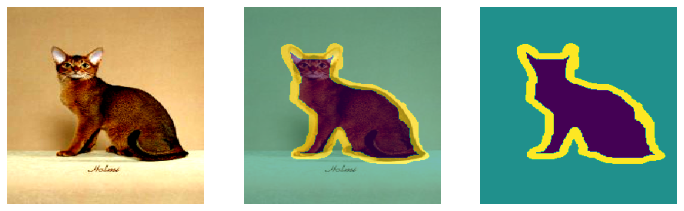

{0.0, 1.0, 2.0}


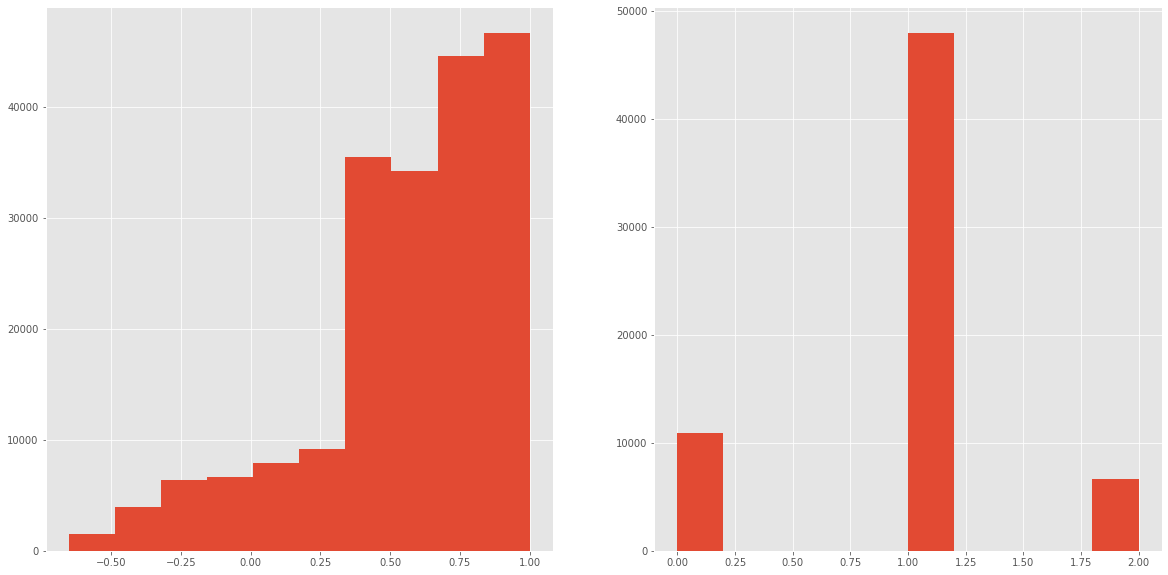

In [ ]:
img_aug, mask_aug = dg.augment(img_pre, mask_pre)
display_img(img_aug, mask_aug)
hist_val(img_aug, mask_aug)

### 데이터셋 정의

In [ ]:
train_ds=dg.generate(train_img_paths[:5000],train_mask_paths[:5000], aug = True)
valid_ds=dg.generate(train_img_paths[5000:],train_mask_paths[5000:])
print(train_ds)
print(valid_ds)

<BatchDataset shapes: ((16, 256, 256, 3), (16, 256, 256, 1)), types: (tf.float32, tf.float32)>
<BatchDataset shapes: ((16, 256, 256, 3), (16, 256, 256, 1)), types: (tf.float32, tf.float32)>


## 모델: 전이학습

### 1. 모델 생성

In [ ]:
base_model = tf.keras.models.load_model("unet_chip.h5")
base_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                             

In [ ]:
from tensorflow.keras import models, layers

NUM_CLASSES = 3
input = base_model.input #(256,256,256)
output = base_model.layers[-2].output
output=layers.Conv2D(NUM_CLASSES, 3, activation= 'softmax', padding = 'same', name ='new_layer')(output)

model = models.Model(inputs=input, outputs=output)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                           

### 2. 모델 컴파일

In [ ]:
from tensorflow.keras import losses, optimizers

loss= losses.SparseCategoricalCrossentropy()
optimizer=optimizers.Adam(learning_rate=0.001)
model.compile(loss=loss,
              optimizer=optimizer,
              metrics=['accuracy'])

### 3. 모델 학습

In [ ]:
from tensorflow.keras import callbacks

es = callbacks.EarlyStopping(monitor='val_loss')
ckp = callbacks.ModelCheckpoint('unet_pet_aug.h5', monitor='val_loss', save_best_only=True)
lr=callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10)

history = model.fit(train_ds,
                    validation_data = valid_ds,
                    epochs =15,
                    callbacks=[ckp,lr]) #학습효과

Epoch 1/15
312/312 [==============================] - ETA: 0s - loss: 0.2830 - accuracy: 0.8922

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


312/312 [==============================] - 187s 601ms/step - loss: 0.2830 - accuracy: 0.8922 - val_loss: 0.2887 - val_accuracy: 0.8938 - lr: 0.0010
Epoch 2/15
312/312 [==============================] - 171s 547ms/step - loss: 0.2749 - accuracy: 0.8947 - val_loss: 0.2804 - val_accuracy: 0.8948 - lr: 0.0010
Epoch 3/15
312/312 [==============================] - 189s 606ms/step - loss: 0.2700 - accuracy: 0.8963 - val_loss: 0.2796 - val_accuracy: 0.8952 - lr: 0.0010
Epoch 4/15
312/312 [==============================] - 190s 610ms/step - loss: 0.2607 - accuracy: 0.8997 - val_loss: 0.2696 - val_accuracy: 0.8982 - lr: 0.0010
Epoch 5/15
312/312 [==============================] - 170s 545ms/step - loss: 0.2579 - accuracy: 0.9010 - val_loss: 0.2883 - val_accuracy: 0.8929 - lr: 0.0010
Epoch 6/15
312/312 [==============================] - 170s 546ms/step - loss: 0.2495 - accuracy: 0.9041 - val_loss: 0.2917 - val_accuracy: 0.8925 - lr: 0.0010
Epoch 7/15
312/312 [==============================] - 188

### 4. 모델 평가

### 5. 추론

In [ ]:
3